# Linear regression

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats

from gaul.modelling import hmc

import matplotlib.pyplot as plt
import seaborn as sns
import corner

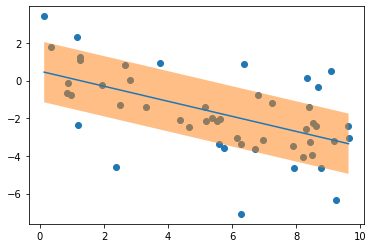

In [4]:
beta0 = 0.5
beta1 = -0.4
sigma = 1.6
n = 50

key = jax.random.PRNGKey(0)
xkey, ykey = jax.random.split(key)

x = jax.random.uniform(xkey, shape=(n,)) * 10.
x = jnp.sort(x)
ymean = beta0 + beta1 * x
y = jax.random.normal(ykey, shape=(n,)) * sigma + ymean

plt.scatter(x, y)
plt.plot(x, ymean)
plt.fill_between(x, ymean - sigma, ymean + sigma, alpha=0.5)

In [5]:
def ln_posterior(params, data):
    target = 0
    target += stats.norm.logpdf(params['beta0'], 0., 2.)
    target += stats.norm.logpdf(params['beta1'], 0., 2.)
    target += stats.expon.logpdf(jnp.exp(params['sigma']), scale=1.)
    ymean = params['beta0'] + params['beta1'] * data['x']
    target += stats.norm.logpdf(data['y'], ymean, jnp.exp(params['sigma'])).sum()
    return target.sum()

In [6]:
params = dict(
    beta0=jnp.zeros(1),
    beta1=jnp.zeros(1),
    sigma=jnp.zeros(1),
)

data = dict(
    x=x,
    y=y,
)

In [7]:
%%time
samples, momentum = hmc.sample(
    ln_posterior,
    params,
    n_chains=10,
    n_samples=5000,
    n_warmup=5000,
    leapfrog_steps=10,
    step_size=1.5e-2,
    data=data
)

Compiling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: user 3.82 s, sys: 11 ms, total: 3.83 s
Wall time: 3.8 s


In [8]:
samples = jax.tree_util.tree_map(lambda x: x.reshape(x.shape[0], -1), samples)

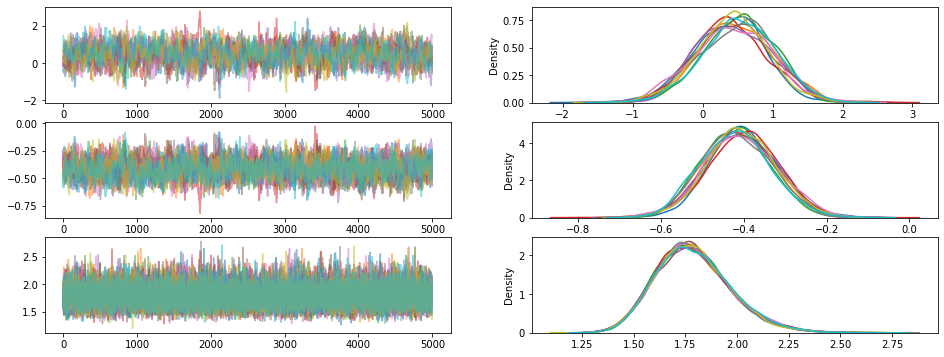

In [9]:
fig, ax = plt.subplots(3, 2, figsize=(16, 6))
for i in range(10):
    ax[0,0].plot(samples['beta0'][i], alpha=0.5)
    ax[1,0].plot(samples['beta1'][i], alpha=0.5)
    ax[2,0].plot(jnp.exp(samples['sigma'][i]), alpha=0.5)
    sns.kdeplot(samples['beta0'][i], ax=ax[0,1])
    sns.kdeplot(samples['beta1'][i], ax=ax[1,1])
    sns.kdeplot(jnp.exp(samples['sigma'][i]), ax=ax[2,1])

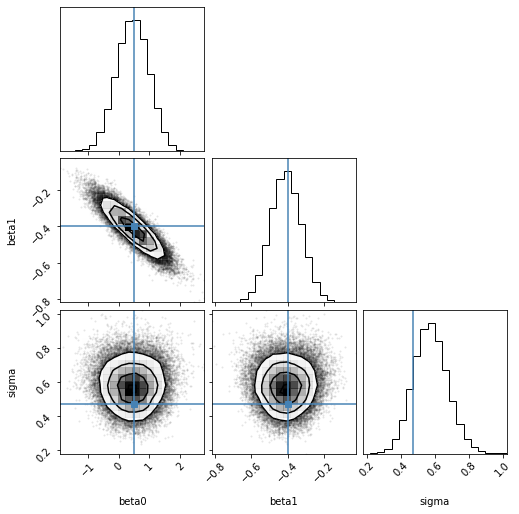

In [10]:
corner.corner(samples, truths=(beta0, beta1, jnp.log(sigma)));